# Setup

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats.mstats import winsorize
from statsmodels.tsa.seasonal import seasonal_decompose

from prophet import Prophet

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



data = pd.read_csv('data/apple_5yr.csv', parse_dates=['Date'])

/opt/anaconda3/envs/anomaly_detection/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Data Prep

In [4]:
# Dropping first row due to NA data
data = data.drop(index=0).reset_index(drop=True)

print(data.head())

print(data.shape)





        Date              Close               High                Low  \
0 2020-06-04  78.32931518554688   79.1312690763083  77.95506657558614   
1 2020-06-05  80.56021881103516  80.62097312386399  78.55046881252456   
2 2020-06-08  81.03653717041016  81.07056314819836  79.54441498185327   
3 2020-06-09  83.59550476074219  83.98919153470604  80.68416273702039   
4 2020-06-10  85.74620819091797  86.21522971767824   84.1058417038533   

                Open     Volume  
0  78.83236263047952   87560400  
1  78.57962969607472  137250400  
2  80.25645380649277   95654400  
3  80.71575616737768  147712400  
4  84.54570234634012  166651600  
(1255, 6)


Converting all data into numeric values

In [5]:
print(data.dtypes)
cols = ["Close", "High", "Low", "Open", "Volume"]

data[cols] = data[cols].apply(pd.to_numeric, errors="coerce")

Date      datetime64[ns]
Close             object
High              object
Low               object
Open              object
Volume            object
dtype: object


# Simple moving average and Exponential smoothing

## Closing Price of Apple from 2020 ~ 2025

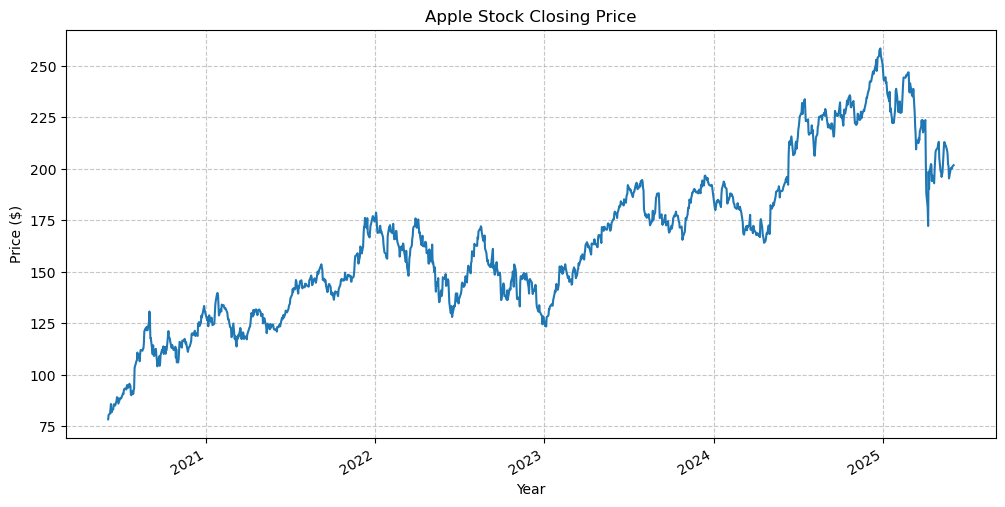

In [6]:
ts = data.set_index("Date")["Close"]

ts.plot(figsize=(12,6), title="Apple Stock Closing Price")
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Simple Moving Average (SMA)

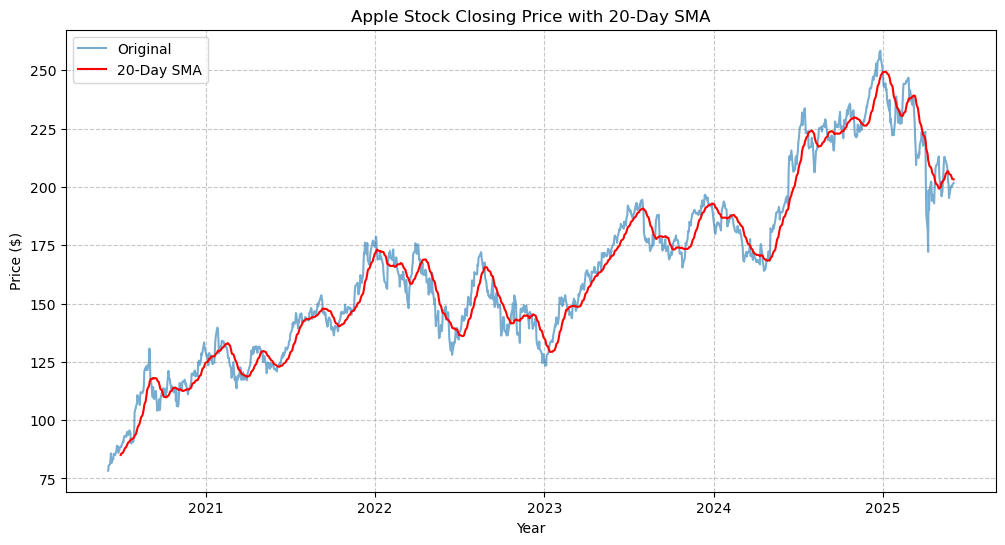

In [7]:
sma = ts.rolling(window=20).mean()

plt.figure(figsize=(12,6))
plt.plot(ts, label='Original', alpha=0.6)
plt.plot(sma, label='20-Day SMA', color='red')
plt.title('Apple Stock Closing Price with 20-Day SMA')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

A 20-day SMA smooths out short-term fluctuations and highlights the longer-term trend. Comparing the original series with SMA reveals where daily prices deviate significantly. As we can see, larger positive or negative gaps between actual and SMA can signal anomalies.

## Risiduals Distribution

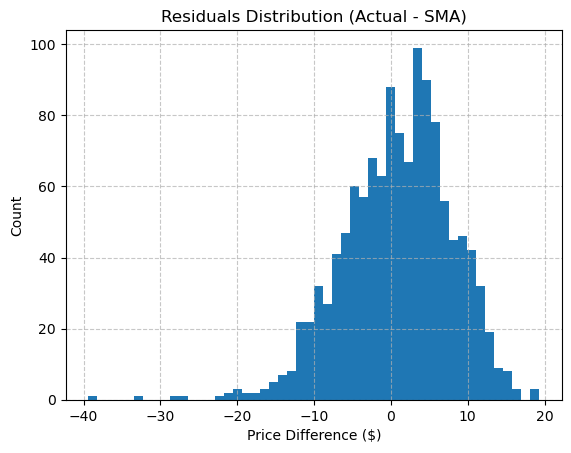

In [8]:
residuals_sma = ts - sma

plt.hist(residuals_sma.dropna(), bins=50)
plt.title("Residuals Distribution (Actual - SMA)")
plt.xlabel('Price Difference ($)')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Residuals mostly cluster near zero, but some extreme values appear. The histogram shows a heavy tail on the negative side, indicating sharp downward moves. This confirms that anomalies are not just visually obvious but also statistically unusual.

## Winsorize residuals to check extreme values

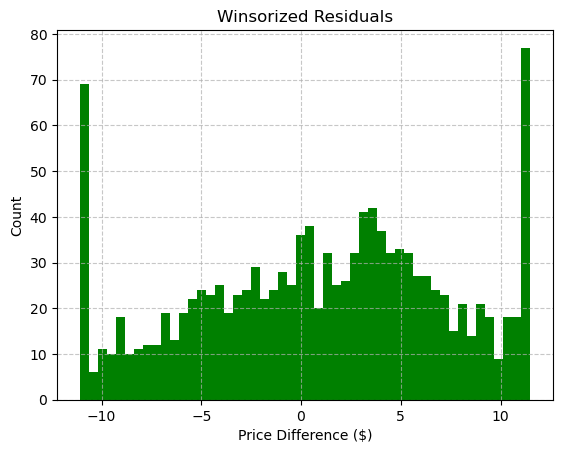

In [9]:
resid_winsorized = winsorize(residuals_sma.dropna(), limits=[0.05, 0.05])
plt.hist(resid_winsorized, bins=50, color="green")
plt.title("Winsorized Residuals")
plt.xlabel('Price Difference ($)')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Winsorizing trims extreme residuals, showing how much anomalies influence the distribution. After winsorizing, the histogram is more symmetric, confirming that extreme values were driving skewness. This helps justify that certain points should be considered anomalies rather than normal fluctuations.

## Exponential Weighted Moving Average (EWMA)

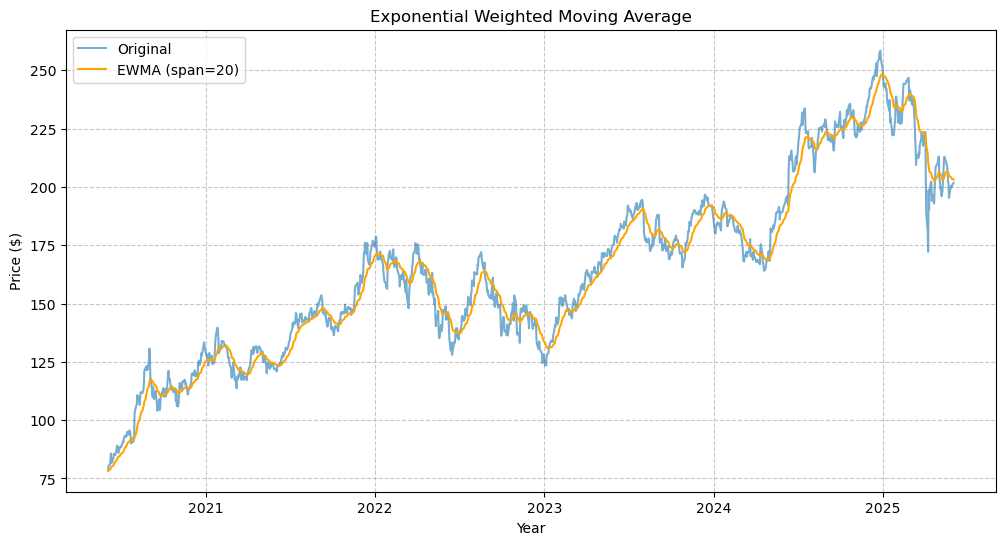

In [10]:
ewma = ts.ewm(span=20, adjust=False).mean()

plt.figure(figsize=(12,6))
plt.plot(ts, label="Original", alpha=0.6)
plt.plot(ewma, label="EWMA (span=20)", color="orange")
plt.title("Exponential Weighted Moving Average")
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


EWMA gives more weight to recent prices, adapting faster than SMA. It follows sharp movements more closely, reducing lag compared to SMA. This makes it more effective at detecting recent anomalies (e.g., sudden price drops).

## Risiduals Distribution for Exponential Weight Moving Average

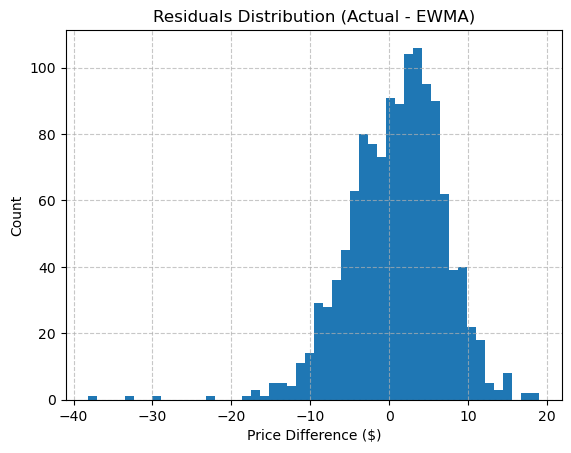

In [11]:
residuals_ewm = ts - ewma
plt.hist(residuals_ewm.dropna(), bins=50)
plt.title("Residuals Distribution (Actual - EWMA)")
plt.xlabel('Price Difference ($)')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Residuals around EWMA are narrower and more centered compared to SMA. Outliers still appear, but fewer extreme deviations remain, showing EWMA’s responsiveness. This demonstrates how different smoothing choices affect anomaly detection sensitivity.

## Automatic Outlier Detection with Rolling Mean & Std

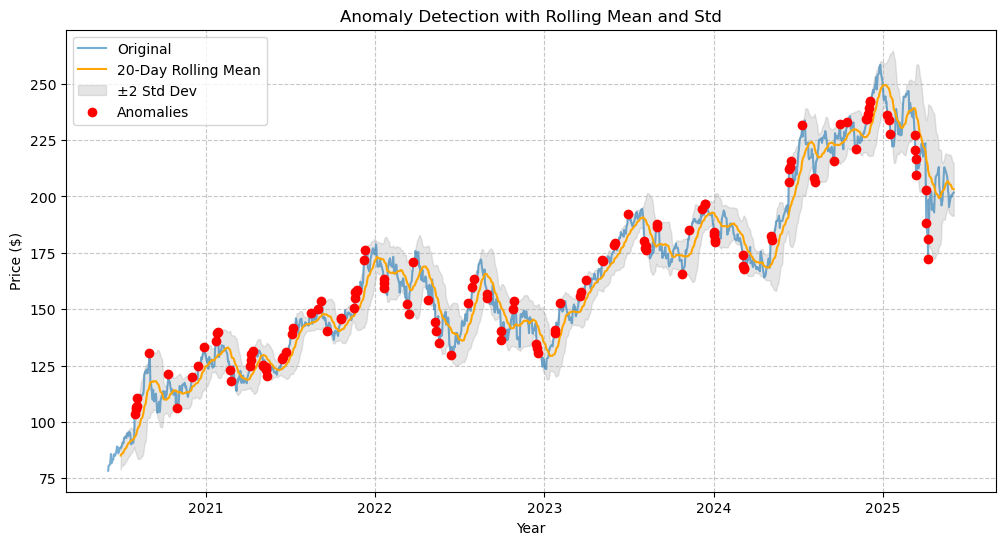

Number of anomalies detected: 126


In [12]:
# Rolling mean and rolling std (20-day window)
rolling_mean = ts.rolling(window=20).mean()
rolling_std = ts.rolling(window=20).std()

# Define anomaly threshold: e.g. 2 standard deviations
upper_bound = rolling_mean + 2 * rolling_std
lower_bound = rolling_mean - 2 * rolling_std

# Find anomalies (where actual price is outside bounds)
anomalies = ts[(ts > upper_bound) | (ts < lower_bound)]


plt.figure(figsize=(12,6))
plt.plot(ts, label="Original", alpha=0.6)
plt.plot(rolling_mean, color="orange", label="20-Day Rolling Mean")
plt.fill_between(ts.index, lower_bound, upper_bound, color="gray", alpha=0.2, label="±2 Std Dev")
plt.scatter(anomalies.index, anomalies, color="red", label="Anomalies", zorder=5)
plt.title("Anomaly Detection with Rolling Mean and Std")
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

print(f"Number of anomalies detected: {len(anomalies)}")


We are using 20-day rolling average to represent the expected price and a rolling standard deviation to represent natural variability. We define anomalies as points where the actual price moves more than 2 standard deviations away from the rolling mean.

The model flagged 126 anomalies across ~5 years of Apple stock Many anomalies can occur during sharp drops (e.g., market corrections, sudden sell-offs) but also during rapid upward spikes (overheating markets).

Compared to SMA/EWMA histograms and winsorizing, this method automatically pinpoints exact days that deviate from “normal” volatility. It shows how anomaly detection can complement smoothing instead of just smoothing the curve.

# Seasonal-Trend Decomposition
While SMA and EWMA highlight anomalies in the historical data, Prophet extends this by decomposing trend/seasonality and allowing us to simulate anomalies in future forecasts.

## Preperation

In [13]:
# Prophet expects columns: ds (date) and y (value)
df = data[["Date", "Close"]].rename(columns={"Date":"ds", "Close":"y"})

# Fitting Prophet model
m = Prophet(daily_seasonality=True)
m.fit(df)

15:24:27 - cmdstanpy - INFO - Chain [1] start processing
15:24:27 - cmdstanpy - INFO - Chain [1] done processing


## Forecasting (no anomaly)

We will be forcasting 1 year into the future.

/opt/anaconda3/envs/anomaly_detection/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/anomaly_detection/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


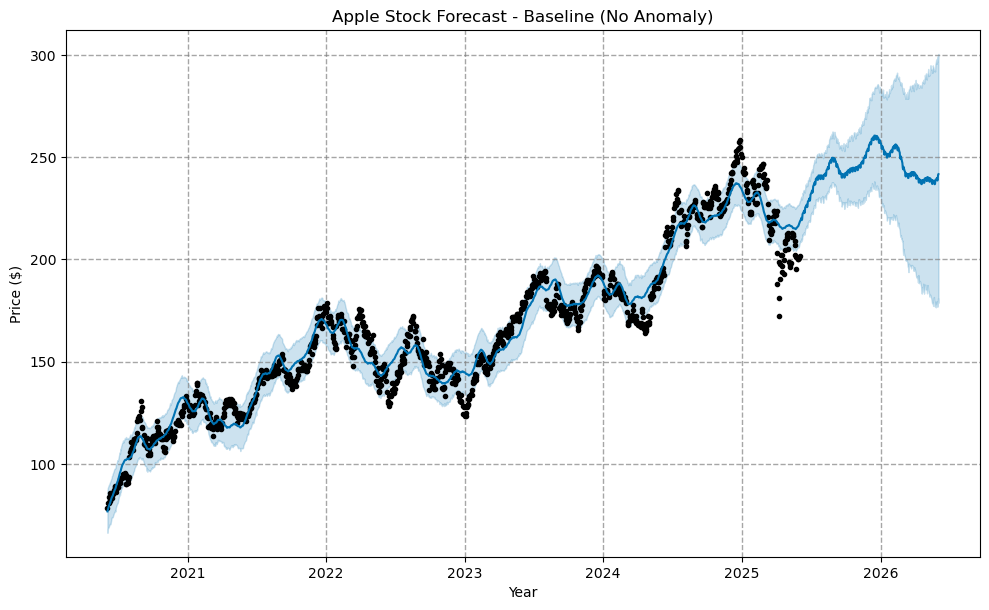

In [14]:
future = m.make_future_dataframe(periods= 365)
forecast = m.predict(future)

fig1 = m.plot(forecast)
plt.title("Apple Stock Forecast - Baseline (No Anomaly)")
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The forecast shows Apple’s stock price continuing its upward trend into the future. The blue line is the predicted median price; the light blue band is the uncertainty interval, which widens over time. Overall, the forecast suggests continued growth, but with large possible variation.

# Decompose into trend/seasonal/holiday (no anomaly)

/opt/anaconda3/envs/anomaly_detection/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/anomaly_detection/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/envs/anomaly_detection/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python date

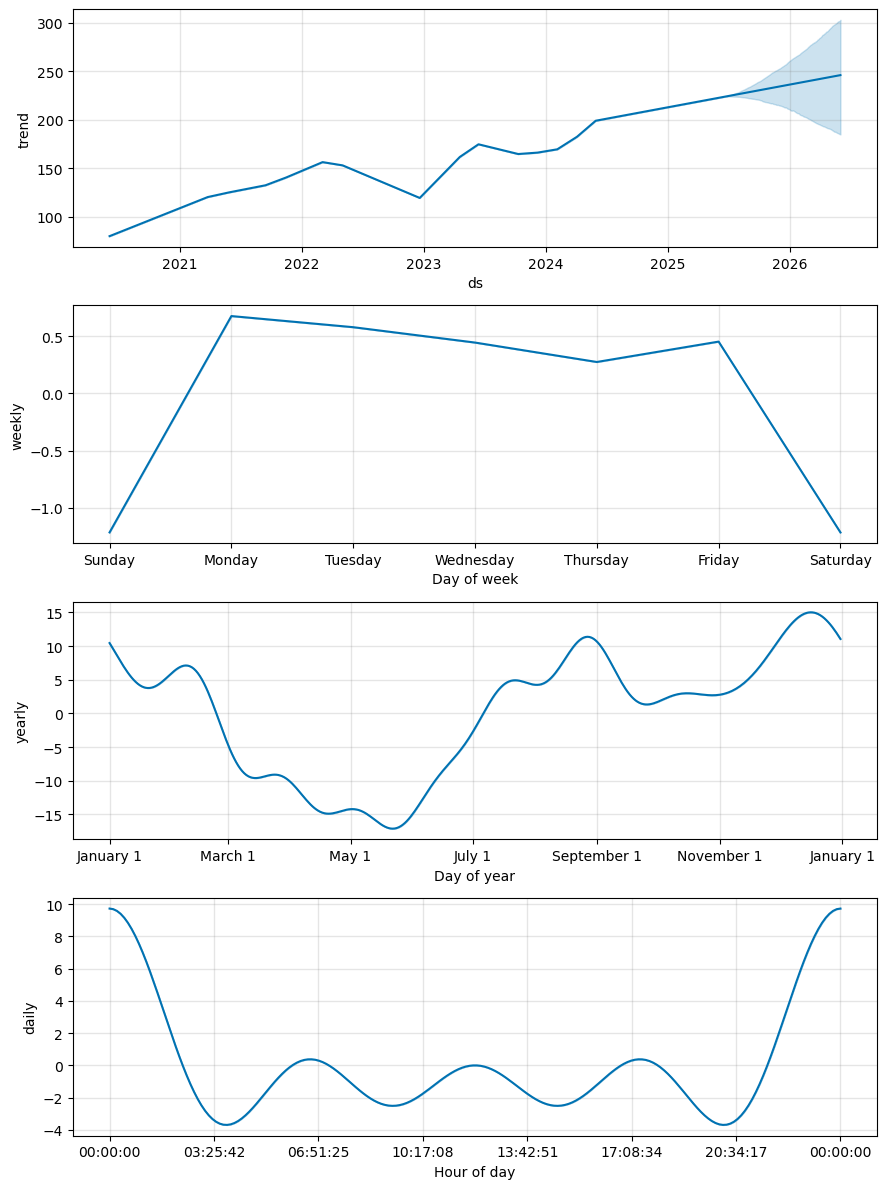

In [15]:
fig2 = m.plot_components(forecast)
plt.show()

Trend: Shows the underlying long-term increase in Apple stock price, consistent with the baseline forecast.

Weekly seasonality: Small pattern reflecting day-of-week effects. These are likely statistical noise because stock markets close on weekends. Prophet still fits them as cycles.

Yearly seasonality: Some periodic fluctuations by month. Again, these are weaker in stock data (not like retail sales), but Prophet picks up patterns such as summer dips or end-of-year rises.

Daily seasonality: This plot is not meaningful for daily stock data (since only one observation per day). It shows Prophet’s default component, but we don’t interpret it for stocks.

Ultimately, the trends reflects long-term growth in Apple’s stock.

## Injecting Custom Anomaly

In [23]:
# Example: sudden "market shock" on March 15, 2026
anomaly = pd.DataFrame({
    'holiday': 'market_shock',
    'ds': pd.to_datetime(['2026-03-15']),
    'lower_window': 0,
    'upper_window': 1
})

# Fit Prophet with anomaly included
m_anomaly = Prophet(daily_seasonality=True, holidays=anomaly)
m_anomaly.fit(df)


15:30:22 - cmdstanpy - INFO - Chain [1] start processing
15:30:23 - cmdstanpy - INFO - Chain [1] done processing


## Forecast (injected anomaly)

/opt/anaconda3/envs/anomaly_detection/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/anomaly_detection/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


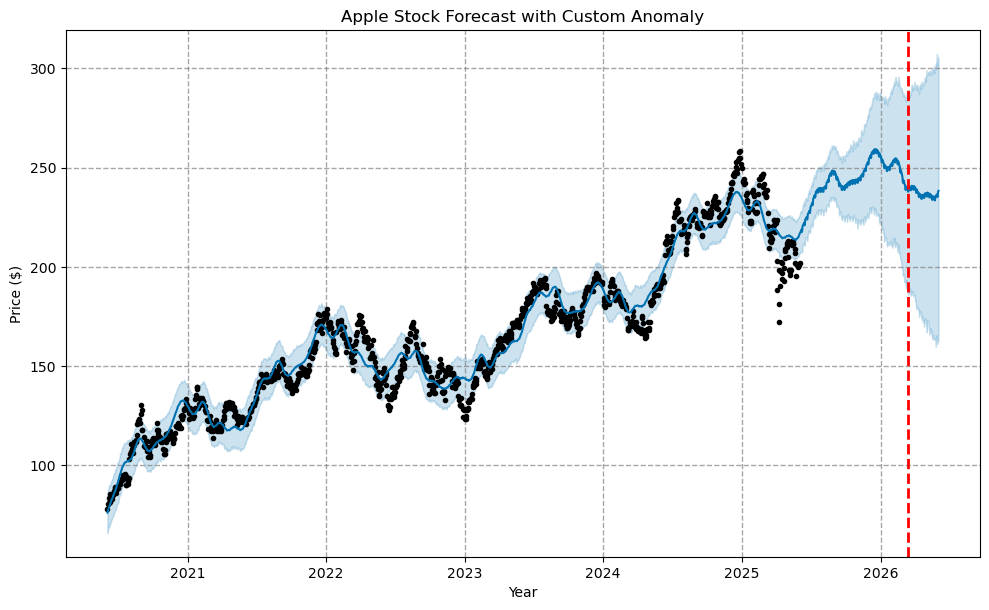

In [24]:
future = m_anomaly.make_future_dataframe(periods=365)
forecast_anomaly = m_anomaly.predict(future)

anomaly_date = pd.to_datetime("2026-03-15")

fig3 = m_anomaly.plot(forecast_anomaly)
plt.title("Apple Stock Forecast with Custom Anomaly")
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(anomaly_date, color="red", linestyle="--", linewidth=2, label="Anomaly Date")
plt.show()

Here we injected a “market shock” holiday on March 15, 2026. The forecast shows a temporary drop around that date, before resuming the long-term upward trend. This demonstrates how Prophet can incorporate exogenous events (“holidays” or anomalies) that affect the time series. In practice, this could model events like earnings surprises, lawsuits, or global crises.

## Seasonal-Trend Decomposition (injected anomaly)

/opt/anaconda3/envs/anomaly_detection/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/anomaly_detection/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/envs/anomaly_detection/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python date

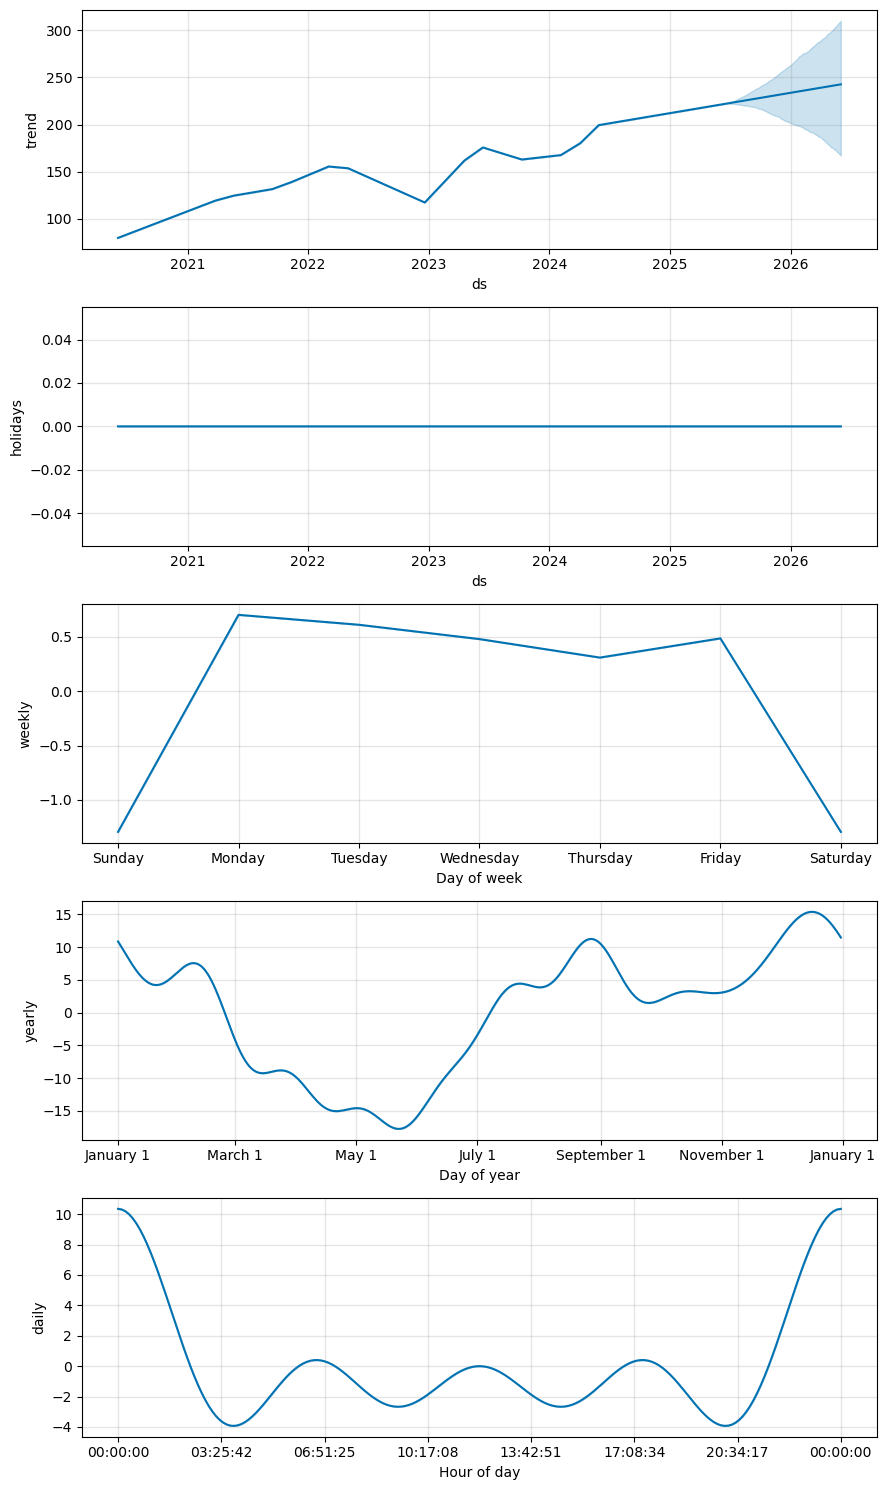

In [25]:
fig4 = m_anomaly.plot_components(forecast_anomaly)
plt.show()

The trend is similar to the baseline, but now it includes a dip at the anomaly date. The holiday component appears flat except at the injected anomaly date, confirming the model recognizes it as an isolated shock. Weekly and yearly seasonality remain the same as in the baseline model.

Ultimately, this shows Prophet isolates the anomaly without distorting other seasonal patterns.

# Closing Remark
This analysis showed how different methods detect and explain anomalies in stock data. SMA and EWMA highlighted local deviations, supported by residual histograms, winsorization, and rolling std thresholds for statistical justification. Prophet extended this by decomposing trend and seasonality and modeling a future “market shock,” showing how anomalies can shift forecasts. Together, these methods provide both historical detection and forward-looking insights that can be useful in many types of continuous data.